# TAOR project: Managing solid waste in Central Portugal

## Setup

In the cell below we will load the core libraries we will be using.

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gp
from shapely.geometry import Point, Polygon, LineString

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# Pyomo
from pyomo.environ import *

# Misc libraries
import os
from time import perf_counter

# Scripting library
import get_basura as gb

## Optimization models

The models are instantiated as Pyomo objects and are solved using the NEOS server. 

### Modified model from Antunes et al (2001)

A minor change is proposed in the objective function from Antunes et al (2001) where the $m$ term is not considered and a constraint is imposed on the maximum number of new transfer stations to be built in the network. This change does not alter the optimal locations of the incinerator nor the transfer stations; however, this modification enforces only cost terms in the objective function.

This model is solved using CPLEX.

In [2]:
# Max distances
demax = 25
dlmax = 125

# Bring the data as dictionaries
q_j, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl = [i for i in gb.get_data(demax, dlmax)]

# Parameters
c_c = 0.045
c_u = 0.128571

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

In [3]:
tic = perf_counter()

# Step 0: Instantiate a model object
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model.w_jk = Var(J, K, within= Binary)
model.v_jl = Var(J, L, within=Binary)
model.y_k = Var(K, within=Binary)
model.z_l = Var(L, within=Binary)
model.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model.x_kl[k,l] for k in K for l in L) #+ sum( m*model.y_k[k] for k in K)

model.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model,J):
    return sum( model.w_jk[J,k] for k in K ) + \
           sum( model.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model,K):
    return sum( q_j[j]*model.w_jk[j, K] for j in J ) == sum( model.x_kl[K,l] for l in L )  
    
def rule_3(model,J,K):
    return model.w_jk[J,K] <= f_jk_f_jl[J,K]*model.y_k[K]

def rule_4(model,J,L):
    return model.v_jl[J,L] <= f_jk_f_jl[J,L]*model.z_l[L]
   
def rule_5(model,K,L):
    return model.x_kl[K,L] <= g_kl[K,L]*q*model.z_l[L]

def rule_6(model,K):
    return sum(q_j[j]*model.w_jk[j,K] for j in J)<=s_k*model.y_k[K]

def rule_7(model):
    return sum(model.z_l[l] for l in L)==1

def rule_8(model, J1, K1):
    return model.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model): #experiment, incinerator not in Agueda
    return (model.z_l["Agueda"] == 0)

def rule_10(model): #experiment, incinerator not in Mealheada
    return (model.z_l["Mealhada"] == 0)

def rule_11(model): #experiment, incinerator not in Anadia
    return (model.z_l["Anadia"] == 0)

def rule_12(model, J1, K1):
    return model.y_k[K1] >= w_jk0[J1, K1]

def rule_13(model):
    return sum(model.y_k[k] for k in K) <= 9

def rule_14(model, J):
    return sum(model.w_jk[J, k] for k in K) <= 9

model.C_1 = Constraint( J, rule=rule_1 )
model.C_2 = Constraint( K, rule=rule_2 )
model.C_3 = Constraint( J, K, rule=rule_3 )
model.C_4 = Constraint( J, L, rule=rule_4 )
model.C_5 = Constraint( K, L, rule = rule_5)
model.C_6 = Constraint( K, rule = rule_6 )
model.C_7 = Constraint( rule = rule_7)
model.C_8 = Constraint(J1, K1, rule = rule_8) 
#model.C_9 = Constraint( rule = rule_9) # experiment, incinerator not in Agueda
#model.C_10 = Constraint( rule = rule_10) # experiment, incinerator not in Mealhada
#model.C_11 = Constraint( rule = rule_11) # experiment, incinerator not in Anadia
#model.c_12 = Constraint( J1, K1, rule = rule_12) # allow the municipalities to go to other ts
model.c_13 = Constraint( rule = rule_13) # limit number of transfer stations without using the m term
#model.c_14 = Constraint( J, rule = rule_14) # limit number of municipalities assigned to a ts

# Call Mosel and solve
results = SolverFactory('amplxpress').solve(model)

# Call the NEOS server and use CPLEX for solving

# email address
# os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

# solver_manager = SolverManagerFactory('neos')
# results = solver_manager.solve(model, opt="cplex")

results.write()

toc = perf_counter()
e_time = toc -tic


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4076
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1327415.82064062; 7 integer solutions have been found; 3 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 2.745459794998169
# ----------------------------------------------------------
#   Solution Information
# -----------

### Results

In [4]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model.Cost():.2f}")
    #t_cost = model.Cost() - m*sum(model.y_k[k]() for k in K)
    #print(f"Transportation costs = €{t_cost:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model.y_k[k]() == 1):
            print(k, model.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model.z_l[l]() == 1):
            print(l, model.z_l[l]())
    
    print(f"\nElapsed time: {e_time:.1f} seconds")
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1327415.82

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Agueda 1.0

Elapsed time: 3.1 seconds


### Visualization

Here are some auxiliary lists that will be used for displaying the maps

In [5]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1)]

#### GIS

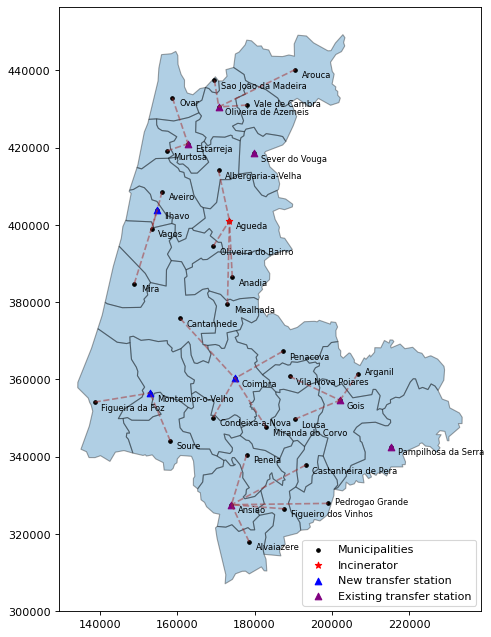

In [6]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

#### Folium map

In [7]:
# Create map instance and display
centro_map = gb.create_folium(ts_new, ts_exist, inc, mun, w_jk, v_jl)
centro_map

## Updated model
This model uses the data from 2019. Costs are also updated to 2019 using the Price index (Índice de Preços no Consumidor - IPC) from the Portuguese Institute of Statistics (INE.pt)

In [8]:
# Max distances
demax = 25
dlmax = 125
drmax = 70

# Bring the new data
new_data = gb.get_new_data(demax, dlmax, drmax)

q_j, q_r, q_jr_max, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl, g_jk = [i for i in new_data]

# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model_rob = ConcreteModel()
model_rob.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model_rob.w_jk = Var(J, K, within= Binary)
model_rob.v_jl = Var(J, L, within=Binary)
model_rob.y_k = Var(K, within=Binary)
model_rob.z_l = Var(L, within=Binary)
model_rob.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model_rob):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_rob.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_rob.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model_rob.x_kl[k,l] for k in K for l in L) #+ sum( m*model.y_k[k] for k in K)

model_rob.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_rob,J):
    return sum( model_rob.w_jk[J,k] for k in K ) + \
           sum( model_rob.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model_rob,K):
    return sum( q_j[j]*model_rob.w_jk[j, K] for j in J ) == sum( model_rob.x_kl[K,l] for l in L )  
    
def rule_3(model_rob,J,K):
    return model_rob.w_jk[J,K] <= f_jk_f_jl[J,K]*model_rob.y_k[K]

def rule_4(model_rob,J,L):
    return model_rob.v_jl[J,L] <= f_jk_f_jl[J,L]*model_rob.z_l[L]
   
def rule_5(model_rob,K,L):
    return model_rob.x_kl[K,L] <= g_kl[K,L]*q*model_rob.z_l[L]

def rule_6(model_rob,K):
    return sum(q_j[j]*model_rob.w_jk[j,K] for j in J)<=s_k*model_rob.y_k[K]

def rule_7(model_rob):
    return sum(model_rob.z_l[l] for l in L)==1

def rule_8(model_rob, J1, K1):
    return model_rob.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model_rob): #experiment, incinerator not in Agueda
    return (model.z_l["Agueda"] == 0)

def rule_10(model_rob): #experiment, incinerator not in Mealheada
    return (model_rob.z_l["Mealhada"] == 0)

def rule_11(model_rob): #experiment, incinerator not in Anadia
    return (model_rob.z_l["Anadia"] == 0)

def rule_12(model_rob, J1, K1):
    return model_rob.y_k[K1] >= w_jk0[J1, K1]

def rule_13(model_rob):
    return sum(model_rob.y_k[k] for k in K) <= 9

def rule_14(model_rob, J):
    return sum(model_rob.w_jk[J, k] for k in K) <= 9

model_rob.C_1 = Constraint( J, rule=rule_1 )
model_rob.C_2 = Constraint( K, rule=rule_2 )
model_rob.C_3 = Constraint( J, K, rule=rule_3 )
model_rob.C_4 = Constraint( J, L, rule=rule_4 )
model_rob.C_5 = Constraint( K, L, rule = rule_5)
model_rob.C_6 = Constraint( K, rule = rule_6 )
model_rob.C_7 = Constraint( rule = rule_7)
model_rob.C_8 = Constraint(J1, K1, rule = rule_8) 
#model_rob.C_9 = Constraint( rule = rule_9) # experiment, incinerator not in Agueda
#model_rob.C_10 = Constraint( rule = rule_10) # experiment, incinerator not in Mealhada
#model_rob.C_11 = Constraint( rule = rule_11) # experiment, incinerator not in Anadia
#model_rob.c_12 = Constraint( J1, K1, rule = rule_12) # allow the municipalities to go to other ts
model_rob.c_13 = Constraint( rule = rule_13) # limit number of transfer stations without using the m term
#model_rob.c_14 = Constraint( J, rule = rule_14) # limit number of municipalities assigned to a ts

# Call Mosel and solve
results = SolverFactory('amplxpress').solve(model_rob)

# Call the NEOS server and use MOSEK for solving

# email address
#os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

#solver_manager = SolverManagerFactory('neos')
#results_rob = solver_manager.solve(model_rob, opt="cplex")

results.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4076
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1639242.314681916; 5 integer solutions have been found; 5 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 2.7563416957855225
# ----------------------------------------------------------
#   Solution Information
# ---------

### Results

In [9]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model_rob.Cost():.2f}")
    #t_cost_rob = model_rob.Cost() - m*sum(model_rob.y_k[k]() for k in K)
    #print(f"Transportation costs = €{t_cost_rob:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model_rob.y_k[k]() == 1):
            print(k, model_rob.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model_rob.z_l[l]() == 1):
            print(l, model_rob.z_l[l]())
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1639242.31

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0


### Visualization

In [10]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model_rob.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model_rob.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model_rob.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model_rob.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1)]

#### GIS

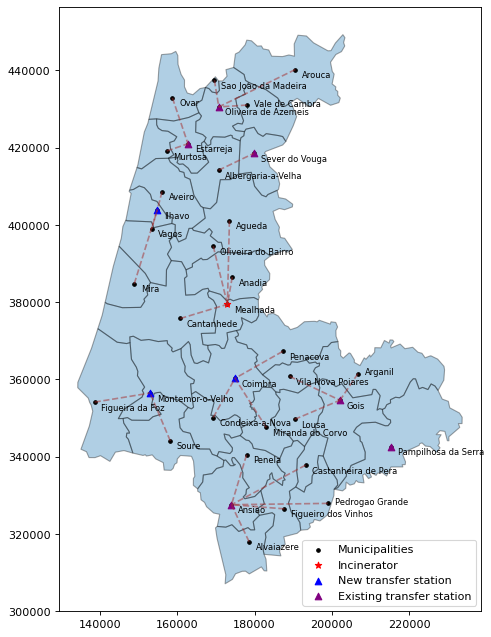

In [11]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

#### Folium map

In [12]:
new_map = gb.create_folium(ts_new, ts_exist, inc, mun, w_jk, v_jl)
new_map

## New model
Recycling centers are now included

In [13]:
# Max distances
demax = 25
dlmax = 125
drmax = 30

# Bring the new data
new_data = gb.get_new_data(demax, dlmax, drmax)

q_j, q_r, q_jr_max, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl, g_jk = [i for i in new_data]

In [14]:
# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# new index set for recycling 
R = ["Paper", "Plastic", "Metals", "Glass", "Wood"]

# Step 2: Define the decision variables
model.w_jk = Var(J, K, within= Binary)
model.v_jl = Var(J, L, within=Binary)
model.y_k = Var(K, within=Binary)
model.z_l = Var(L, within=Binary)
model.x_kl = Var(K,L, domain = NonNegativeReals)

# new Decision Variables
model.X_k = Var(K, within = Binary) # If we build a recycle center in "k"
model.u_jk = Var(J, K, within= Binary) # If from "j" we send to recycle center "k"

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model.x_kl[k,l] for k in K for l in L) +\
        sum( c_u * dist_jk_dist_jl[j,k] * q_r[j] * model.u_jk[j,k] for j in J for k in K )

model.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model,J):
    return sum( model.w_jk[J,k] for k in K ) + \
           sum( model.v_jl[J,l] for l in L ) == 1

def rule_2(model,J):
    return sum( model.u_jk[J,k] for k in K ) == 1  
    
def rule_3(model,K):
    return sum( q_j[j]*model.w_jk[j, K] for j in J ) == sum( model.x_kl[K,l] for l in L )  

# def rule_2_b(model,K):
#     return sum( q_r[j]*model.u_jk[j, K] for j in J ) == model.X_k[K]  
    
def rule_4(model,J,K):
    return model.w_jk[J,K] <= f_jk_f_jl[J,K]*model.y_k[K]

def rule_5(model,J,K):
    return model.u_jk[J,K] <= g_jk[J,K]*model.X_k[K]

def rule_6(model,J,L):
    return model.v_jl[J,L] <= f_jk_f_jl[J,L]*model.z_l[L]
   
def rule_7(model,K,L):
    return model.x_kl[K,L] <= g_kl[K,L]*q*model.z_l[L]

def rule_8(model,K):
    return sum(q_j[j]*model.w_jk[j,K] for j in J) <= s_k*model.y_k[K]

def rule_9(model, K):
    return sum(q_r[j]*model.u_jk[j,K] for j in J) <= s_k*model.X_k[K]

def rule_10(model):
    return sum(model.z_l[l] for l in L)==1

def rule_11(model, J1, K1):
    return model.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_12(model):
    return sum(model.y_k[k] for k in K) <= 9

def rule_13(model):
    return sum(model.X_k[k] for k in K) <= 9

model.C_1 = Constraint( J, rule=rule_1 )
model.C_2 = Constraint( J, rule=rule_2 )
model.C_3 = Constraint( K, rule=rule_3 )
model.C_4 = Constraint( J, K, rule=rule_4 )
model.C_5 = Constraint(J, K, rule = rule_5)
model.C_6 = Constraint( J, L, rule=rule_6 )
model.C_7 = Constraint( K, L, rule = rule_7)
model.C_8 = Constraint( K, rule = rule_8 )
model.C_9 = Constraint( K, rule = rule_9 )
model.C_10 = Constraint( rule = rule_10)
model.C_11 = Constraint(J1, K1, rule = rule_11) 
model.c_12 = Constraint( rule = rule_12) # limit number of transfer stations without using the m term
model.c_13 = Constraint( rule = rule_13) # limit number of recycling centers

# Call Mosel and solve
results = SolverFactory('amplxpress').solve(model)

# email address
#os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

#solver_manager = SolverManagerFactory('neos')
#results = solver_manager.solve(model, opt="cplex")

results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 5445
  Number of variables: 5292
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1728561.3651107305; 5 integer solutions have been found; 5 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 2.2817537784576416
# ----------------------------------------------------------
#   Solution Information
# --------

### Results

In [15]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model.Cost():.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model.y_k[k]() == 1):
            print(k, model.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model.z_l[l]() == 1):
            print(l, model.z_l[l]())

    print("\nRecycling centers:")
    for k in K:
        if(model.X_k[k]() == 1):
            print(k, model.X_k[k]())
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1728561.37

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0

Recycling centers:
Anadia 1.0
Aveiro 1.0
Oliveira de Azemeis 1.0
Ovar 1.0
Coimbra 1.0
Figueira da Foz 1.0
Pampilhosa da Serra 1.0
Vila Nova Poiares 1.0
Ansiao 1.0


### Visualization

In [16]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model.z_l[l]() == 1):
        z.append(l)

#Recycling centres
x = []

for k in K:
    if(model.X_k[k]() == 1):
        x.append(k)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Link between municipalities and recycling centres
links_recs = []

for k in K:
    for j in J:
        if(model.u_jk[j, k]() == 1):
            links_recs.append((k, j))

# Get the coordinates
ts_new, ts_exist, inc, rec, mun, w_jk, v_jl, u_jk = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1, x, links_recs)]

### GIS

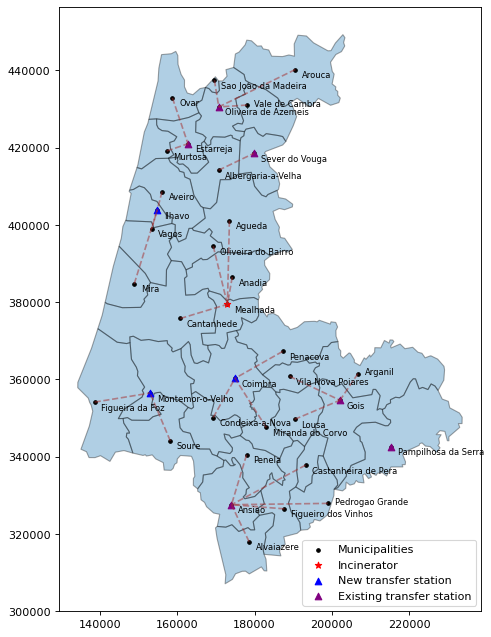

In [17]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

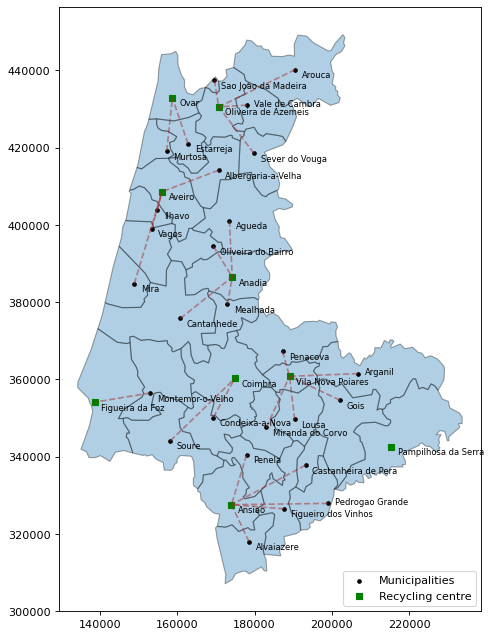

In [18]:
gis_rec_map = gb.create_gis_rec(rec, u_jk)
gis_rec_map

## Anti-median

In [19]:
# Max distances
demax = 25
dlmax = 125
drmax = 30

# Bring the new data
new_data = gb.get_new_data(demax, dlmax, drmax)

q_j, q_r, q_jr_max, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl, g_jk = [i for i in new_data]

In [20]:
# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

weight = 100

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# new index set for recycling 
R = ["Paper", "Plastic", "Metals", "Glass", "Wood"]

# Step 2: Define the decision variables
model.w_jk = Var(J, K, within= Binary)
model.v_jl = Var(J, L, within=Binary)
model.y_k = Var(K, within=Binary)
model.z_l = Var(L, within=Binary)
model.x_kl = Var(K,L, domain = NonNegativeReals)

# new Decision Variables
model.X_k = Var(K, within = Binary) # If we build a recycle center in "k"
model.u_jk = Var(J, K, within= Binary) # If from "j" we send to recycle center "k"

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model.x_kl[k,l] for k in K for l in L) +\
        sum( c_u * dist_jk_dist_jl[j,k] * q_r[j] * model.u_jk[j,k] for j in J for k in K ) -\
        sum( weight * model.X_k[j] * dist_jk_dist_jl[j, k] * model.X_k[k] for j in J for k in K)


model.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model,J):
    return sum( model.w_jk[J,k] for k in K ) + \
           sum( model.v_jl[J,l] for l in L ) == 1

def rule_2(model,J):
    return sum( model.u_jk[J,k] for k in K ) == 1  
    
def rule_3(model,K):
    return sum( q_j[j]*model.w_jk[j, K] for j in J ) == sum( model.x_kl[K,l] for l in L )  

# def rule_2_b(model,K):
#     return sum( q_r[j]*model.u_jk[j, K] for j in J ) == model.X_k[K]  
    
def rule_4(model,J,K):
    return model.w_jk[J,K] <= f_jk_f_jl[J,K]*model.y_k[K]

def rule_5(model,J,K):
    return model.u_jk[J,K] <= g_jk[J,K]*model.X_k[K]

def rule_6(model,J,L):
    return model.v_jl[J,L] <= f_jk_f_jl[J,L]*model.z_l[L]
   
def rule_7(model,K,L):
    return model.x_kl[K,L] <= g_kl[K,L]*q*model.z_l[L]

def rule_8(model,K):
    return sum(q_j[j]*model.w_jk[j,K] for j in J) <= s_k*model.y_k[K]

def rule_9(model, K):
    return sum(q_r[j]*model.u_jk[j,K] for j in J) <= s_k*model.X_k[K]

def rule_10(model):
    return sum(model.z_l[l] for l in L)==1

def rule_11(model, J1, K1):
    return model.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_12(model):
    return sum(model.y_k[k] for k in K) <= 9

def rule_13(model):
    return sum(model.X_k[k] for k in K) <= 8

model.C_1 = Constraint( J, rule=rule_1 )
model.C_2 = Constraint( J, rule=rule_2 )
model.C_3 = Constraint( K, rule=rule_3 )
model.C_4 = Constraint( J, K, rule=rule_4 )
model.C_5 = Constraint(J, K, rule = rule_5)
model.C_6 = Constraint( J, L, rule=rule_6 )
model.C_7 = Constraint( K, L, rule = rule_7)
model.C_8 = Constraint( K, rule = rule_8 )
model.C_9 = Constraint( K, rule = rule_9 )
model.C_10 = Constraint( rule = rule_10)
model.C_11 = Constraint(J1, K1, rule = rule_11) 
model.c_12 = Constraint( rule = rule_12) # limit number of transfer stations without using the m term
model.c_13 = Constraint( rule = rule_13) # limit number of recycling centers

# Call Mosel and solve
results = SolverFactory('amplxpress').solve(model)

# email address
#os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

#solver_manager = SolverManagerFactory('neos')
#results = solver_manager.solve(model, opt="cplex")

results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 5445
  Number of variables: 5292
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1279818.9117319335; 15 integer solutions have been found; 6966 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 10.526829957962036
# ----------------------------------------------------------
#   Solution Information
# ----

## Results

In [21]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model.Cost():.2f}")
    t_cost = model.Cost() + sum(weight*model.X_k[j]() * dist_jk_dist_jl[j, k] * model.X_k[k]() for j in J for k in K)
    print(f"Transportation costs = €{t_cost:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model.y_k[k]() == 1):
            print(k, model.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model.z_l[l]() == 1):
            print(l, model.z_l[l]())

    print("\nRecycling centers:")
    for k in K:
        if(model.X_k[k]() == 1):
            print(k, model.X_k[k]())
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1279818.91
Transportation costs = €1766918.91

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0

Recycling centers:
Arouca 1.0
Aveiro 1.0
Oliveira de Azemeis 1.0
Arganil 1.0
Coimbra 1.0
Figueira da Foz 1.0
Pampilhosa da Serra 1.0
Figueiro dos Vinhos 1.0


## Results

In [22]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model.z_l[l]() == 1):
        z.append(l)

#Recycling centres
x = []

for k in K:
    if(model.X_k[k]() == 1):
        x.append(k)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Link between municipalities and recycling centres
links_recs = []

for k in K:
    for j in J:
        if(model.u_jk[j, k]() == 1):
            links_recs.append((k, j))

# Get the coordinates
ts_new, ts_exist, inc, rec, mun, w_jk, v_jl, u_jk = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1, x, links_recs)]

### GIS

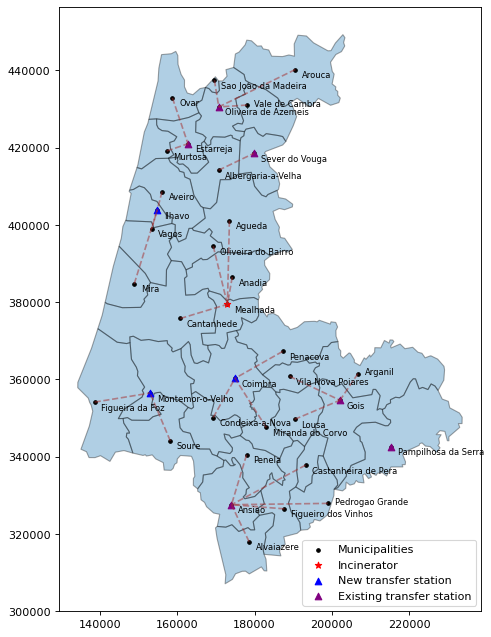

In [23]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

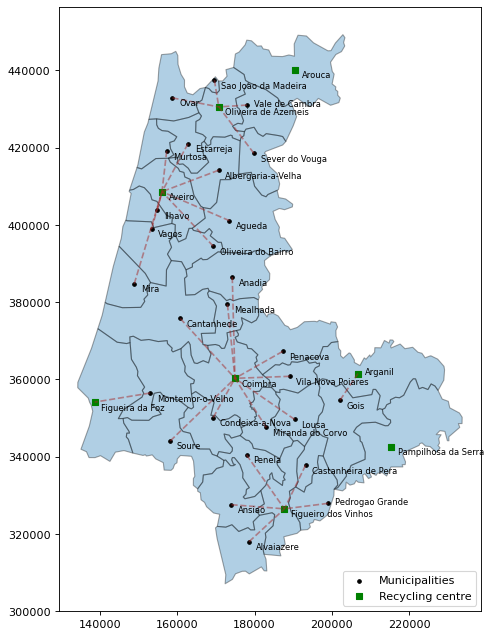

In [24]:
gis_rec_map = gb.create_gis_rec(rec, u_jk)
gis_rec_map

In [17]:
# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# new Parameters
p_r = [10, 10, 10, 10, 10] # placeholder value. Vector. Profit of recyclying material R
c_r = [10, 10, 10, 10, 10] # placeholder value. Vector. Cost of recyclying material R
c_Tr = [10, 10, 10, 10, 10] # placeholder value. Vector. Cost of transporting unit of material R for unit of distance
C_size = 10 # placeholder value. scalar. Cost of km2 of building
C_setup = 10 # placeholder value. scalar. Cost of setup the facility (search this one )

Q_jr_max = q_jr_max # placeholder value. matrix. Maximum amount of recyclable waste "r" from "j" (This will be coming from excel)
Q_jN_max = q_j # placeholder value. vector. Maximum amount of NOT recyclable waste from "j"
M = 1E10

# Step 0: Instantiate a model object
model_rob = ConcreteModel()
model_rob.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# new index set for recycling 
R = ["Paper", "Plastic", "Metals", "Glass", "Wood"]

# Step 2: Define the decision variables
model_rob.w_jk = Var(J, K, within= Binary)
model_rob.v_jl = Var(J, L, within=Binary)
model_rob.y_k = Var(K, within=Binary)
model_rob.z_l = Var(L, within=Binary)
model_rob.x_kl = Var(K,L, domain = NonNegativeReals)

# new Decision Variable
model_rob.q_jk = Var(J, K, domain = NonNegativeReals) # how much not recyclable waste from "j" to ts "k"
model_rob.q_jl = Var(J, L, domain = NonNegativeReals) # how much not recyclable waste from "j" to incinerator "l"
model_rob.q_jkr = Var(J, K, R, domain = NonNegativeReals) # how much recyclable waste from "j" to recycling "r" in "k"
model_rob.S_kr = Var(K, R, domain = NonNegativeReals) # size of plant for recycling "r" in "k"
model_rob.X_kr = Var(K, R, within = Binary) # If we build plant for "r" in recycle center "k"
model_rob.u_jk = Var(J, K, R, within= Binary) # If from "j" we send "r" to recycle center "k"

# Step 3: Objective function
def obj_rule(model_rob):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_rob.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_rob.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model_rob.x_kl[k,l] for k in K for l in L) +\
        sum( c_u * dist_jk_dist_jl[j,k] * Q_jr_max[j, r] * model_rob.u_jk[j,k] for j in J for k in K for r in R)

#def obj_rule_new(model_rob):
    #return sum( c_u * dist_jk_dist_jl[j,k] * model_rob.q_jk[j,k] for j in J for k in K) + \
        #sum( c_u * dist_jk_dist_jl[j,l] * model_rob.q_jl[j,l] for j in J for l in L) + \
        #sum( c_c * dist_kl[k,l] * model_rob.x_kl[k,l] for k in K for l in L) + \
        #sum( c_u * dist_jk_dist_jl[j,k]* model_rob.q_jkr[j,k,r] for j in J for k in K for r in R)
        #sum(C_size * model_rob.S_kr[k,r] for k in K for r in R) + sum(C_setup * model_rob.X_kr[k,r] for k in K for r in R)
        
model_rob.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_rob,J):
    return sum( model_rob.w_jk[J,k] for k in K ) <= 1 

def rule_1_a(model_rob,J):
    return sum( model_rob.v_jl[J,l] for l in L ) <= 1 

def rule_1_b(model_rob,J,R): # maybe not necessary, we cannot send r from j to more than one recycle center k
    return sum( model_rob.u_jkr[J,k, R] for k in K ) <= 1 

def rule_2(model_rob,J,K):
    return (model_rob.q_jk[J,K] <= model_rob.w_jk[J, K] * M ) # to know j can send to ts k

def rule_2_b(model_rob,J,L):
    return ( model_rob.q_jl[J,L] <= model_rob.v_jl[J, L] * M ) # to know j can send to incinerator l

def rule_2_c(model_rob,J,K,R):
    return ( model_rob.q_jkr[J,K,R] <= model_rob.u_jkr[J, K, R] * Q_jr_max[J,R] ) # upper bound material r from j that can be send to rec. cent k

def rule_2_d(model_rob,J): # min amount of not recyclabe waste that must be hauled to ts or incinerator
    return sum(model_rob.q_jk[J,k] for k in K) + sum(model_rob.q_jl[J,l] for l in L) >= Q_jN_max[J]

def rule_2_e(model_rob,J): # waste conservation
    return sum(model_rob.q_jk[J,k] for k in K) + sum(model_rob.q_jl[J,l] for l in L) + sum(model_rob.q_jkr[J,k,r] for k in K for r in R) == Q_jN_max[J] + sum(Q_jr_max[J,r] for r in R)

def rule_6(model_rob,K):
    return sum(model_rob.q_jk[j,K] for j in J) == sum(model_rob.x_kl[K,l] for l in L)

def rule_3(model_rob,J,K):
    return model_rob.w_jk[J,K] <= f_jk_f_jl[J,K]*model_rob.y_k[K]

def rule_4(model_rob,J,L):
    return model_rob.v_jl[J,L] <= f_jk_f_jl[J,L]*model_rob.z_l[L]
   
def rule_5(model_rob,K,L):
    return model_rob.x_kl[K,L] <= g_kl[K,L]*model_rob.z_l[L]*M

def rule_6_b(model_rob,K):
    return sum(model_rob.q_jk[j,K] for j in J)<=sum(s_k*model_rob.y[K] for k in K)

def rule_7(model_rob):
    return sum(model_rob.z_l[l] for l in L)==1

def rule_8(model_rob, J1, K1):
    return model_rob.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model_rob,J,K,R):
    return model_rob.u_jkr[J,K,R] <=  f_jk_f_jl[J,K]*model_rob.X_kr[K,R]

def rule_10(model_rob,K,R):
    return model_rob.S_kr[K,R] <= model_rob.X_kr[K,R]*M #big M or a limited capacity for the buildings?

def rule_13(model_rob):
    return sum(model_rob.y_k[k] for k in K) <= 9 # do we take it?

model_rob.C_1 = Constraint( J, rule=rule_1 )
model_rob.C_2 = Constraint( J, K, rule=rule_2 )
model_rob.C_3 = Constraint( J, K, rule=rule_3 )
model_rob.C_4 = Constraint( J, L, rule=rule_4 )
model_rob.C_5 = Constraint( K, L, rule = rule_5)
model_rob.C_6 = Constraint( K, rule = rule_6 )
model_rob.C_7 = Constraint( rule = rule_7)
model_rob.C_8 = Constraint(J1, K1, rule = rule_8) 
model_rob.c_13 = Constraint( rule = rule_13) # limit number of transfer stations without using the m term

# Call Mosel and solve
#results = SolverFactory('amplxpress').solve(model_rob)

# Call the NEOS server and use MOSEK for solving

# email address
os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

#solver_manager = SolverManagerFactory('neos')
#results_rob = solver_manager.solve(model_rob, opt="cplex")

#results_rob.write()


ERROR: Rule failed when generating expression for objective Cost: KeyError:
    "Index '('Agueda', 'Agueda')' is not valid for indexed component 'u_jk'"
ERROR: Constructing component 'Cost' from data=None failed: KeyError: "Index
    '('Agueda', 'Agueda')' is not valid for indexed component 'u_jk'"


KeyError: "Index '('Agueda', 'Agueda')' is not valid for indexed component 'u_jk'"